# Modelos de regresión

In [1]:
!pip install gpboost
!pip install shap
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely import wkt

# Modelos
import gpboost as gpb
import shap
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler


/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Lectura de datos 

In [3]:
data = pd.read_csv('./data/modelling_data.csv',  index_col=[0])

In [4]:
data.head()

,id,antig,m2total,m2cub,ambientes,banios,precioUSD,m2precioUSD,comisaria_dista,obelisco_dista,...,clas_ambientes_1,clas_ambientes_2,clas_ambientes_3,clas_ambientes_4,clas_ambientes_5,clas_banios_0,clas_banios_1,clas_banios_2,clas_banios_3,clas_banios_4
0,1,0,200,200,0,0,1500000,7500.000000,1162.621600,14053.797191,...,0,0,0,0,0,1,0,0,0,0
1,2,30,50,50,0,1,125000,2500.000000,1887.227055,13473.139375,...,0,0,0,0,0,0,1,0,0,0
2,3,30,414,414,0,2,590000,1425.120773,1497.020434,13514.662463,...,0,0,0,0,0,0,0,1,0,0
3,4,35,414,414,0,2,730000,1763.000000,1506.066814,13495.631683,...,0,0,0,0,0,0,0,1,0,0
4,5,35,285,285,0,1,550000,1929.000000,1506.066814,13495.631683,...,0,0,0,0,0,0,1,0,0,0


In [5]:
y = data.precioUSD
X = data.drop("precioUSD", axis = 1)

In [6]:
X.head()

,id,antig,m2total,m2cub,ambientes,banios,m2precioUSD,comisaria_dista,obelisco_dista,nrobos,...,clas_ambientes_1,clas_ambientes_2,clas_ambientes_3,clas_ambientes_4,clas_ambientes_5,clas_banios_0,clas_banios_1,clas_banios_2,clas_banios_3,clas_banios_4
0,1,0,200,200,0,0,7500.000000,1162.621600,14053.797191,134,...,0,0,0,0,0,1,0,0,0,0
1,2,30,50,50,0,1,2500.000000,1887.227055,13473.139375,23,...,0,0,0,0,0,0,1,0,0,0
2,3,30,414,414,0,2,1425.120773,1497.020434,13514.662463,33,...,0,0,0,0,0,0,0,1,0,0
3,4,35,414,414,0,2,1763.000000,1506.066814,13495.631683,33,...,0,0,0,0,0,0,0,1,0,0
4,5,35,285,285,0,1,1929.000000,1506.066814,13495.631683,33,...,0,0,0,0,0,0,1,0,0,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.33, random_state=42)

coords_train = X_train[['lon_planar', 'lat_planar']]
coords_test = X_test[['lon_planar', 'lat_planar']]

In [8]:
features = ['id', 'lon_planar', 'lat_planar', 'banios', 'ambientes']

In [9]:
X_train = X_train.drop(features, axis = 1)
X_test = X_test.drop(features, axis = 1)

In [10]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

## Aplicamos la transformación de escala sobre los features
scaler_X.fit(X_train)
X_scaled_train = scaler_X.transform(X_train)
X_scaled_test  = scaler_X.transform(X_test)

## Aplicamos la transformación de escala sobre la variable objetivo
## Observación: StandardScaler toma como input una matriz. Si queremos darle un
## vector (como por ej. para utilizar con la variable objetivo), tenemos que 
## transformar ese vector en una matriz de una sola columna. Esto lo hacemos
## con el método 'reshape'
scaler_y.fit(y_train.values.reshape(-1, 1))
y_scaled_train = scaler_y.transform(y_train.values.reshape(-1, 1))[:,0]
y_scaled_test  = scaler_y.transform(y_test.values.reshape(-1, 1))[:,0]

In [ ]:
gp_model = gpb.GPModel(gp_coords = coords_train, cov_function="exponential")
data_train = gpb.Dataset(X_train, y_train)
params = { 'objective': 'regression_l2', 'verbose': 0 }
# Training
bst = gpb.train(params=params, train_set=data_train,
                gp_model=gp_model, num_boost_round=247)
gp_model.summary() # Estimated covariance parameters
# Prediction
pred = bst.predict(data=X_test, gp_coords_pred=coords_test,
                    predict_var=True)
# Sum the predictions of the trees and the GP
y_pred = pred['fixed_effect'] + pred['random_effect_mean']

In [24]:
## Utilizaremos la raiz cuadrada del error cuadrático medio como 
## medida del error
def rmse(y1, y2):
    """
    Raiz cuadrada del error cuadrático medio.
    """
    return np.sqrt(mean_squared_error(y1, y2))

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_test  = scaler_y.inverse_transform(y_pred)

In [27]:
rmse(y_test, pred_test)

343725324852.4464

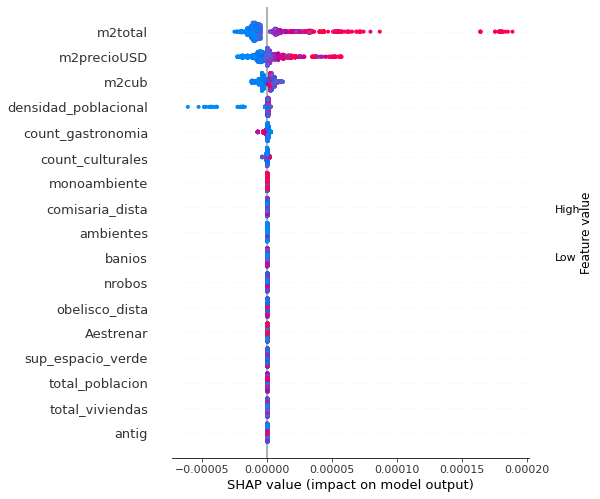

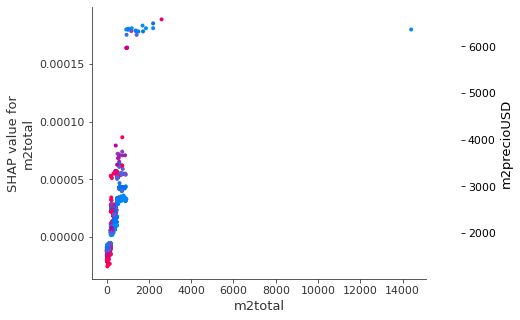

In [28]:
shap_values = shap.TreeExplainer(bst).shap_values(X_train)
shap.summary_plot(shap_values, X_train)
shap.dependence_plot("m2total", shap_values, X_train)

In [ ]:
# --------------------Parameter tuning using a validation set----------------
# Define training and validation data by setting indices of 'folds'
n = len(X_train_
permut = np.random.RandomState(10).choice(a=n, size=n, replace=False)
train_idx = permut[0:int(n/2)]
valid_idx = permut[int(n/2):n]
folds = [(train_idx, valid_idx)]
# Parameter tuning using validation data
opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid_small,
                                             params=params,
                                             folds=folds,
                                             gp_model=gp_model,
                                             use_gp_model_for_validation=True,
                                             train_set=data_train,
                                             verbose_eval=1,
                                             num_boost_round=1000, 
                                             early_stopping_rounds=10,
                                             seed=1000,
                                             metrics='binary_logloss')
print("Best number of iterations: " + str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))
print("Best parameters: " + str(opt_params['best_params']))

## XGBoost

In [28]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE

In [31]:
# import packages for hyperparameters tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error
import time

In [32]:
# Definicion de la funcion de pérdida del RMSE
def RMSLE(y, y_pred):
    """ 
    Función de costo del rmse
    """
    return (np.sqrt(mean_squared_error(y, y_pred)))

# Definicion del scoring para usar en la validación
rmsle_loss = make_scorer(RMSLE, greater_is_better=False)

In [33]:
param_grid={"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
             "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
             "min_child_weight" : [ 1, 3, 5, 7 ],
             "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
             "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

model = xg.XGBRegressor()


In [ ]:
# Configuración de la validación cruzada anidada
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# Iterar por las divisiones del dataset original
rmse_train_results = list() # Guardar el error de train
rmse_test_results = list() # Guardar el error de test
best_score = float("+inf") # Indicador para elegir el mejor ajuste

for train_ix, test_ix in cv_outer.split(X_scaled_train):
    # Comienzo del contador
    start = time.time()
    # Dividir los datos. El set de train se subdivide en una nueva muestra de train y test
    X_train_outer, X_test_outer = X_scaled_train[train_ix, :], X_scaled_train[test_ix, :]
    y_train_outer, y_test_outer = y_scaled_train[train_ix], y_scaled_train[test_ix]
    
    # Configuración de la validacion interna
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)

    # Definir la busqueda
    search = RandomizedSearchCV(model, param_grid, scoring=rmsle_loss, cv=cv_inner, n_iter = 100,
                                refit=True, verbose = 0, n_jobs = None)
    # Ejecutar busqueda
    result = search.fit(X_train_outer, y_train_outer)
    # Seleccionar el mejor modelo para esa submuestra
    best_model_iteration = result.best_estimator_
    # Evaluar el modelo elegido con los datos de test de la submuestra
    pred_train = scaler_y.inverse_transform(best_model_iteration.predict(X_train_outer))
    pred_test  = scaler_y.inverse_transform(best_model_iteration.predict(X_test_outer))
    # Convertir la variable objetivo a su escala original
    train_rescaled = scaler_y.inverse_transform(y_train_outer)
    test_rescaled  = scaler_y.inverse_transform(y_test_outer)
    # Calcular métricas de error
    train_rmse_values = RMSLE(pred_train, train_rescaled)
    test_rmse_values = RMSLE(pred_test, test_rescaled)
    # Evaluar el modelo. Si la performance en test mejora, se selecciona
    if best_score > test_rmse_values:
        best_model = result.best_estimator_
        best_score = test_rmse_values
    # Guardar resultados del error en cada iteración
    rmse_train_results.append(train_rmse_values)
    rmse_test_results.append(test_rmse_values)
    # Reporte de progreso
    print('>RMSE_train=%.3f, RMSE_test=%.3f score = %.3f, param = %s' % (train_rmse_values, test_rmse_values, result.best_score_, result.best_params_))
    
    # Finalizar contador
    stop = time.time()
    print("La iteración tomó", round(stop-start, 3), "segundos.")


# Resumen de la perfomance del modelo
print('RMSE_train: %.3f (%.3f)' % (np.mean(rmse_train_results), np.std(rmse_train_results)))
print('RMSE_test: %.3f (%.3f)' % (np.mean(rmse_test_results), np.std(rmse_test_results)))

In [ ]:
# Ajustar el modelo con todos los datos
best_model.fit(X_scaled_train, y_scaled_train)

In [35]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_train = scaler_y.inverse_transform(best_model.predict(X_scaled_train))
pred_test  = scaler_y.inverse_transform(best_model.predict(X_scaled_test))

print('Train RMSE:', RMSLE(pred_train, y_train))
print('Test RMSE:', RMSLE(pred_test, y_test))

Train RMSE: 58250.75694237299
Test RMSE: 157645.51802997984


## Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestRegressor()


In [34]:
# Configuración de la validación cruzada anidada
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# Iterar por las divisiones del dataset original
rmse_train_results = list() # Guardar el error de train
rmse_test_results = list() # Guardar el error de test
best_score = float("+inf") # Indicador para elegir el mejor ajuste

for train_ix, test_ix in cv_outer.split(X_scaled_train):
    # Comienzo del contador
    start = time.time()
    # Dividir los datos. El set de train se subdivide en una nueva muestra de train y test
    X_train_outer, X_test_outer = X_scaled_train[train_ix, :], X_scaled_train[test_ix, :]
    y_train_outer, y_test_outer = y_scaled_train[train_ix], y_scaled_train[test_ix]
    
    # Configuración de la validacion interna
    cv_inner = KFold(n_splits=10, shuffle=True, random_state=1)

    # Definir la busqueda
    search = RandomizedSearchCV(model, param_grid, scoring=rmsle_loss, cv=cv_inner, n_iter = 100,
                                refit=True, verbose = 0, n_jobs = -1)
    # Ejecutar busqueda
    result = search.fit(X_train_outer, y_train_outer)
    # Seleccionar el mejor modelo para esa submuestra
    best_model_iteration = result.best_estimator_
    # Evaluar el modelo elegido con los datos de test de la submuestra
    pred_train = scaler_y.inverse_transform(best_model_iteration.predict(X_train_outer))
    pred_test  = scaler_y.inverse_transform(best_model_iteration.predict(X_test_outer))
    # Convertir la variable objetivo a su escala original
    train_rescaled = scaler_y.inverse_transform(y_train_outer)
    test_rescaled  = scaler_y.inverse_transform(y_test_outer)
    # Calcular métricas de error
    train_rmse_values = RMSLE(pred_train, train_rescaled)
    test_rmse_values = RMSLE(pred_test, test_rescaled)
    # Evaluar el modelo. Si la performance en test mejora, se selecciona
    if best_score > test_rmse_values:
        best_model = result.best_estimator_
        best_score = test_rmse_values
    # Guardar resultados del error en cada iteración
    rmse_train_results.append(train_rmse_values)
    rmse_test_results.append(test_rmse_values)
    # Reporte de progreso
    print('>RMSE_train=%.3f, RMSE_test=%.3f score = %.3f, param = %s' % (train_rmse_values, test_rmse_values, result.best_score_, result.best_params_))
    
    # Finalizar contador
    stop = time.time()
    print("La iteración tomó", round(stop-start, 3), "segundos.")


# Resumen de la perfomance del modelo
print('RMSE_train: %.3f (%.3f)' % (np.mean(rmse_train_results), np.std(rmse_train_results)))
print('RMSE_test: %.3f (%.3f)' % (np.mean(rmse_test_results), np.std(rmse_test_results)))

>RMSE_train=7575.665, RMSE_test=12368.701 score = -0.615, param = {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
La iteración tomó 350.509 segundos.
>RMSE_train=7196.225, RMSE_test=17195.162 score = -0.616, param = {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
La iteración tomó 363.56 segundos.
>RMSE_train=11714.975, RMSE_test=14762.239 score = -0.629, param = {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
La iteración tomó 343.647 segundos.
>RMSE_train=5748.369, RMSE_test=18846.343 score = -0.603, param = {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': True}
La iteración tomó 381.511 segundos.
>RMSE_train=5815.479, RMSE_test=19426.180 score = -0.601, param = {'n_esti

In [39]:
# Ajustar el modelo con todos los datos
best_model.fit(X_scaled_train, y_scaled_train)

RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=1600)

In [40]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_train = scaler_y.inverse_transform(best_model.predict(X_scaled_train))
pred_test  = scaler_y.inverse_transform(best_model.predict(X_scaled_test))

print('Train RMSE:', RMSLE(pred_train, y_train))
print('Test RMSE:', RMSLE(pred_test, y_test))

Train RMSE: 11103.697589986303
Test RMSE: 17493.789975693086


Feature importance

In [41]:
train_features = list(X_train.columns)

In [42]:
base_imp = imp_df(train_features, best_model.feature_importances_)
base_imp

,feature,feature_importance
0,lotsize,0.351192
1,bathrooms,0.129103
2,garage,0.105629
3,aircon,0.104928
4,bedrooms,0.072179
5,stories,0.071990
6,prefer,0.044396
7,recreation,0.040679
8,fullbase,0.039813
9,driveway,0.021912


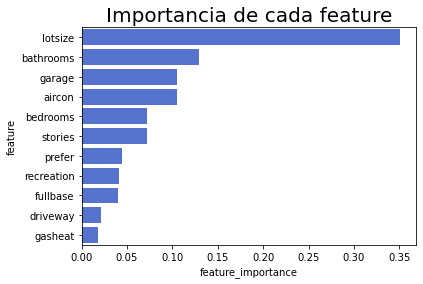

In [44]:
var_imp_plot(base_imp, 'Importancia de cada feature')